In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9


In [20]:
import pandas as pd

df=pd.read_csv(r'/root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9/train.csv',encoding="latin1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [21]:
df.shape

(27481, 10)

In [22]:
df = df[['text', 'sentiment']]

In [23]:
df.isnull().sum()

,0
text,1
sentiment,0


In [24]:
df.dropna(inplace=True)

<ipython-input-24-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [25]:
df.isnull().sum()

,0
text,0
sentiment,0


In [26]:
df = df[:5000].reset_index(drop=True)
df.shape

(5000, 2)

In [27]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,2022
positive,1593
negative,1385


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='count', ylabel='sentiment'>

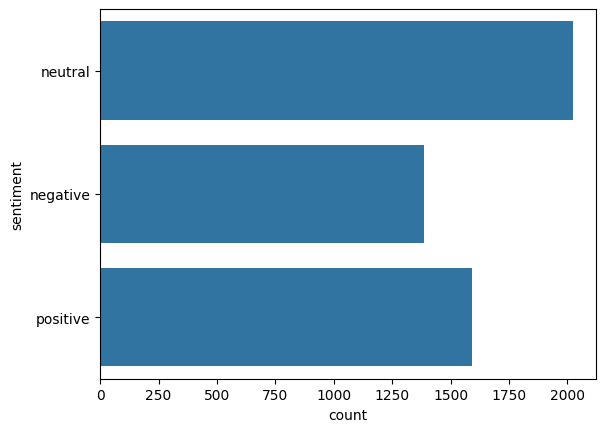

In [29]:
sns.countplot(df['sentiment'])

In [30]:
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [31]:
mapping = {
    "neutral": 0,
    "negative": 1,
    "positive":2
}

In [32]:
class_names = ['neutral', 'negative', 'positive']

In [33]:
df['sentiment'] = df['sentiment'].map(mapping)

In [34]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,1
2,my boss is bullying me...,1
3,what interview! leave me alone,1
4,"Sons of ****, why couldn`t they put them on t...",1


In [35]:
!pip install transformers

# Token length

In [36]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [37]:
token_len = []

for txt in df['text']:
  tokens = tokenizer.encode(txt)
  token_len.append(len(tokens))

In [38]:
max(token_len)

110

Text(0.5, 9.444444444444438, 'Token count')

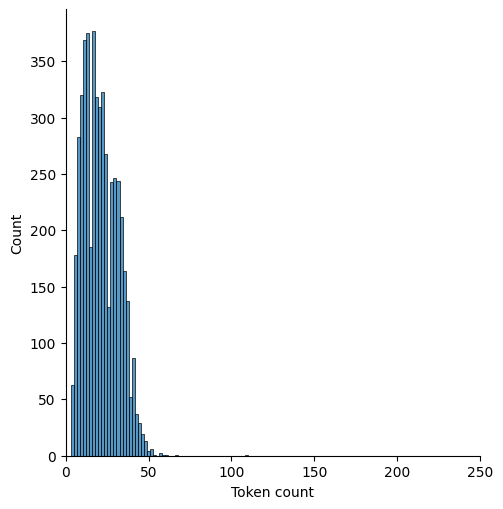

In [39]:
sns.displot(token_len)
plt.xlim([0, 250])
plt.xlabel("Token count")

In [40]:
MAX_LEN = 80

# Dataset and DataLoader

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

In [42]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [43]:
len(train_df), len(test_df), len(val_df)

(4000, 500, 500)

In [44]:
class CustomDataset(Dataset):
  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, idx):
    review = self.review[idx]

    encodings = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return {
        "review_text": review,
        "input_ids": encodings['input_ids'].flatten(),
        "attention_mask": encodings['attention_mask'].flatten(),
        "targets": torch.tensor(self.target[idx], dtype=torch.long)
    }

In [45]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CustomDataset(
      review = df['text'].to_numpy(),
      target = df['sentiment'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size
  )

In [46]:
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, batch_size=16)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, batch_size=16)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, batch_size=16)

In [47]:
a = next(iter(train_data_loader))
a.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

# Create a Model

In [48]:
embed_dim = 256

class SentimentRNNModel(nn.Module):
  def __init__(self, n_classes):
    super(SentimentRNNModel, self).__init__()
    self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim=embed_dim)

    # self.rnn = nn.LSTM(
    #     input_size=embed_dim,
    #     hidden_size=128,
    #     num_layers=2,
    #     batch_first=True,
    #     dropout=0.2,
    #     bidirectional=True
    # )

    self.rnn = nn.RNN(
        input_size=embed_dim,
        hidden_size=128,
        batch_first=True,
        dropout=0.2
    )
    self.fc = nn.Linear(128, n_classes)

  def forward(self, input_ids):
    embedded = self.embedding(input_ids) # use BERT embeddings
    output, hidden = self.rnn(embedded)
    output = self.fc(hidden[-1]) # use the last hiddenstate
    return output

In [49]:
tokenizer.vocab_size

30522

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [51]:
model = SentimentRNNModel(len(class_names))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [52]:
model = model.to(device)

# ------------------- Test -------------------

In [53]:
a = next(iter(train_data_loader))
a.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [54]:
input_ids = a['input_ids']
attention_mask = a['attention_mask']
targets = a['targets']

In [55]:
model(input_ids)

tensor([[-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668],
        [-0.5405, -0.3653, -0.2668]], grad_fn=<AddmmBackward0>)

In [56]:
outputs = model(input_ids)
_, preds = torch.max(outputs, dim=1)
preds

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [57]:
outputs = model(input_ids)
preds = torch.argmax(outputs, dim=1)
preds

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# ------------------- Test complete -------------------

In [58]:
EPOCHS = 10
LEARNING_RATE = 2e-5
total_steps = len(train_data_loader)*EPOCHS


loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [59]:
def train_epoch(model, data_loader, device, loss_fn, optimizer, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids)
    preds = torch.argmax(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    losses.append(loss.item())
    correct_predictions += torch.sum(preds == targets)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)



In [60]:
def eval_model(model, data_loader, device, loss_fn, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      targets = d['targets'].to(device)

      outputs = model(input_ids)
      preds = torch.argmax(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      losses.append(loss.item())
      correct_predictions += torch.sum(preds == targets)

  return correct_predictions.double()/n_examples, np.mean(losses)


In [61]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f"Epoch: {epoch + 1}/{EPOCHS}")
  print('-'*100)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      device,
      loss_fn,
      optimizer,
      scheduler,
      len(train_df)
  )

  print(f"Train loss: {train_loss}, accuracy: {train_acc}")

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      device,
      loss_fn,
      len(val_df)
  )

  print(f"Validation loss: {val_loss}, accuracy: {val_acc}")
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_rnn.bin')
    best_accuracy = val_acc

Epoch: 1/10
----------------------------------------------------------------------------------------------------
Train loss: 1.091509673833847, accuracy: 0.39225
Validation loss: 1.0799992140382528, accuracy: 0.414

Epoch: 2/10
----------------------------------------------------------------------------------------------------
Train loss: 1.0882744019031525, accuracy: 0.40425
Validation loss: 1.0802576523274183, accuracy: 0.414

Epoch: 3/10
----------------------------------------------------------------------------------------------------
Train loss: 1.0881750464439393, accuracy: 0.40425
Validation loss: 1.080509528517723, accuracy: 0.414

Epoch: 4/10
----------------------------------------------------------------------------------------------------
Train loss: 1.0880684156417846, accuracy: 0.40425
Validation loss: 1.0807032715529203, accuracy: 0.414

Epoch: 5/10
----------------------------------------------------------------------------------------------------
Train loss: 1.0879494

(0.0, 1.0)

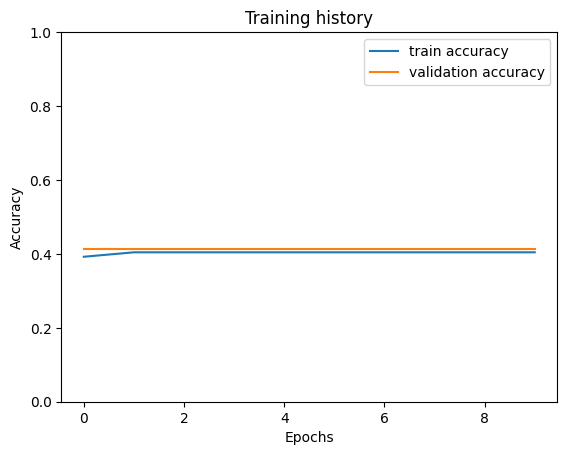

In [62]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

plt.plot([t.cpu().item() for t in history['train_acc']], label='train accuracy')
plt.plot([t.cpu().item() for t in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.ylim([0, 1])

In [63]:
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    device,
    loss_fn,
    len(test_df)
)

print(f"Test loss: {test_loss}, accuracy: {test_acc}")

Test loss: 1.0854471698403358, accuracy: 0.394


# Single prediction

In [64]:
text = "I love completing my todos! Best app ever!!"

In [65]:
encoding = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors="pt"
)

input_ids = encoding['input_ids'].to(device)

output = model(input_ids)
pred = torch.argmax(output)

print(f"Prediction: {class_names[pred]}")

Prediction: neutral
